In [2]:
###############
#Import Dependencies
##############

import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import pyrubberband as pyrb
from scipy import interpolate
from pydub import AudioSegment
from sklearn.cluster import KMeans
from IPython.display import Audio
import scipy
from essentia.standard import *
import essentia.streaming as ess
import essentia.standard as es
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import sounddevice as sd
from typing import Optional, List
from Mix50.process import Process

In [33]:
class Effects():

    def __init__(self):
        pass
    
    def load_audio(self, path:str):
        '''
        Load Audio File into memory
        '''
        
        self.path = path
        self.y, self.sr = librosa.load(path, sr=22050)
    
    def beats(self) -> pd.DataFrame:
        """
        Identify transition points in an audio sample, similar to DJ's beat matching.

        Analyzes the audio to find points where transitions are likely to occur based on changes in energy or beat. 
        Uses tempo and beat detection, filtering, RMS feature extraction, and clustering to identify these points.

        Returns
        -------
        pd.DataFrame
            DataFrame of transition points in seconds. Includes columns for beats, downbeats, loop cues, and transitions.
        """

        # Detect tempo and beats using librosa
        tempo, beats = librosa.beat.beat_track(y=self.y, sr=self.sr)
        beat_times = [round(i, 3) for i in librosa.frames_to_time(beats)]

        # Low-pass filter setup
        cutoff_hz = 70
        nyquist = 0.5 * self.sr
        normal_cutoff = cutoff_hz / nyquist
        b, a = scipy.signal.butter(8, normal_cutoff, btype='low')

        # Apply low-pass filter to audio
        y_low = scipy.signal.lfilter(b, a, self.y)
        y_perc = librosa.effects.percussive(self.y, margin=5)
        y_perc = scipy.signal.lfilter(b, a, y_perc)

        # RMS and smoothing parameters
        window_duration = 0.05
        frame_length = int(window_duration * self.sr)
        hop_length = frame_length // 2

        # RMS calculation and smoothing
        rms_df = pd.DataFrame({
            'RMS': librosa.feature.rms(y=self.y, frame_length=frame_length, hop_length=hop_length)[0],
            'SMA': pd.Series(librosa.feature.rms(y=self.y, frame_length=frame_length, hop_length=hop_length)[0]).rolling(150, center=True).mean().fillna(0),
            'low': librosa.feature.rms(y=y_low, frame_length=frame_length, hop_length=hop_length)[0],
            'SMA_low': pd.Series(librosa.feature.rms(y=y_low, frame_length=frame_length, hop_length=hop_length)[0]).rolling(150, center=True).mean().fillna(0),
            'perc': librosa.feature.rms(y=y_perc, frame_length=frame_length, hop_length=hop_length)[0],
            'SMA_perc': pd.Series(librosa.feature.rms(y=y_perc, frame_length=frame_length, hop_length=hop_length)[0]).rolling(40, center=True).mean().fillna(0),
        })

        # Calculate percentage change and completion
        rms_df['PCT'] = rms_df['RMS'].pct_change()
        rms_df['completion'] = rms_df.index / len(rms_df)

        # Scale and weight features
        scaler = StandardScaler()
        features = ['SMA_low', 'SMA_perc', 'SMA', 'low']
        X_scaled = scaler.fit_transform(rms_df[features])
        X_weighted = X_scaled * [1, 0.4, 1, 0.2]

        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=2, random_state=42)
        rms_df['clusters'] = kmeans.fit_predict(X_weighted)

        # Identify transition points
        rms_df['cue'] = rms_df['clusters'].diff().ne(0).astype(int)
        rms_df['seconds'] = round(rms_df['completion'] * librosa.get_duration(y=self.y), 2)

        # Retrieve cues and find closest values to beats
        onset = rms_df[rms_df.cue == 1]['seconds'].values
        if len(onset) == 0:
            return pd.DataFrame(columns=['beats', 'downbeat', 'loop_cues', 'transitions'])

        differences = [abs(value - onset[0]) for value in beat_times]
        idx_pos = differences.index(min(differences))
        closest_value = beats[idx_pos]

        # Calculate downbeats, loop cues, and transitions
        downbeat = beat_times[idx_pos::-4][::-1][:-1] + beat_times[idx_pos::4]
        loop_cues = beat_times[idx_pos::-16][::-1][:-1] + beat_times[idx_pos::16]
        transitions = [min(loop_cues, key=lambda x: abs(x - value)) for value in onset]

        # Create beat DataFrame with results
        beat_df = pd.DataFrame({'beats': beat_times})
        beat_df['downbeat'] = beat_df['beats'].apply(lambda x: x if x in downbeat else None)
        beat_df['loop_cues'] = beat_df['beats'].apply(lambda x: x if x in loop_cues else None)
        beat_df['transitions'] = beat_df['beats'].apply(lambda x: x if x in transitions else None)
        self.beat_df = beat_df
        
        return beat_df
    
    
    def transition_points(self) -> np.ndarray:
        '''
        Retrieve transition points from the processed beat DataFrame.

        This method extracts transition points from the `beat_df` DataFrame, which should be populated by the `.beats()` method.
        Transition points represent significant changes or cues in the audio data that were identified during the beat analysis.

        Returns
        -------
        np.ndarray
            An array of transition points, which are significant moments in the audio where transitions occur. 
            NaN values are excluded from the output.

        Raises
        ------
        AttributeError
            If the `beat_df` attribute is not set (i.e., if `.beats()` has not been called before this method), an error message is printed
            and the method returns an empty list.

        Notes
        -----
        - Ensure that the `.beats()` method is executed before calling this method to populate the `beat_df` attribute.
        - The `beat_df` DataFrame is expected to have a column named 'transitions' which contains the transition points.

        Examples
        --------
        To retrieve transition points after running the `.beats()` method:

        >>> audio.beats()  # First, compute beats and transitions
        >>> transitions = audio.transition_points()  # Retrieve transition points
        >>> print(transitions)
        [12.34, 56.78, ...]

        '''

        try:
            # Check if data exists
            beat_df = self.beat_df
        except AttributeError:
            # Print custom error message and return early to prevent plotting
            print("Error: Please run the method '.beats()' first.")
            return
        
        transition_points = beat_df.transitions.values
        transition_points = transition_points[~np.isnan(transition_points)]
        
        return list(transition_points)
            
    
    def show_transition_points(self):
        '''
        Show transition points on a waveplot
        '''

        try:
            # Check if data exists
            beat_df = self.beat_df
        except AttributeError:
            # Print custom error message and return early to prevent plotting
            print("Error: Please run the method '.beats()' first.")
            return

        # If no exception, proceed with plotting
        plt.figure(figsize=(14, 5))
        librosa.display.waveshow(self.y, sr=self.sr, alpha=0.7)

        for t in list(beat_df.transitions):
            plt.axvline(x=t, color='r', linestyle='--', label='Transition Point')

        plt.title('Waveplot with Transition Points')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend(['Transition Point'], loc='upper right')
        plt.show()
        
        
    def beat_matching(self) -> pd.DataFrame:
        '''
        Retrieve downbeats using MonoLoader 
        '''
        
        #Load Audio
        audio = MonoLoader(filename=self.path)()

        # Compute beat positions and BPM
        rhythm_extractor = RhythmExtractor2013(method="multifeature")
        bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)

        beat_df = pd.DataFrame({'beats':beats})

        return beat_df


    def bpm(self) -> int:
        '''
        Retrieve BPM using MonoLoader 
        '''

        #Load audio
        audio = es.MonoLoader(filename=self.path)()

        # Compute beat positions and BPM.
        rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
        bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)
        
        return round(bpm,0)
    

    def key(self) -> str:
        '''
        Retrieve Key using Essentia 
        '''

        # Initialize Monoloader
        loader = ess.MonoLoader(filename=self.path)
        framecutter = ess.FrameCutter(frameSize=4096, hopSize=2048, silentFrames='noise')
        windowing = ess.Windowing(type='blackmanharris62')
        spectrum = ess.Spectrum()
        spectralpeaks = ess.SpectralPeaks(orderBy='magnitude',
                                          magnitudeThreshold=0.00001,
                                          minFrequency=20,
                                          maxFrequency=3500,
                                          maxPeaks=60)

        hpcp = ess.HPCP()
        hpcp_key = ess.HPCP(size=36, # We will need higher resolution for Key estimation.
                            referenceFrequency=440, # Assume tuning frequency is 44100.
                            bandPreset=False,
                            minFrequency=20,
                            maxFrequency=1500,
                            weightType='cosine',
                            nonLinear=False,
                            windowSize=1.)

        key = ess.Key(profileType='edma', # Use profile for electronic music.
                      numHarmonics=4,
                      pcpSize=36,
                      slope=0.6,
                      usePolyphony=True,
                      useThreeChords=True)

        # Use pool to store data.
        pool = essentia.Pool()

        # Connect streaming algorithms.
        loader.audio >> framecutter.signal
        framecutter.frame >> windowing.frame >> spectrum.frame
        spectrum.spectrum >> spectralpeaks.spectrum
        spectralpeaks.magnitudes >> hpcp.magnitudes
        spectralpeaks.frequencies >> hpcp.frequencies
        spectralpeaks.magnitudes >> hpcp_key.magnitudes
        spectralpeaks.frequencies >> hpcp_key.frequencies
        hpcp_key.hpcp >> key.pcp
        hpcp.hpcp >> (pool, 'tonal.hpcp')
        key.key >> (pool, 'tonal.key_key')
        key.scale >> (pool, 'tonal.key_scale')
        key.strength >> (pool, 'tonal.key_strength')

        essentia.run(loader)

        return "Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale']


    def fade_out(self, start_time:int, fade_duration:int) -> object:
        '''
        Apply a fade-out effect to the audio signal.

        Parameters
        ----------
        start_time : int
            The time in seconds from which the fade-out effect should begin.
        fade_duration : int
            The duration in seconds over which the fade-out effect should be applied.

        Notes
        -----
        The fade-out effect gradually reduces the volume of the audio signal to silence
        over the specified duration. The effect is applied starting from the given start time.
        The audio signal is modified in place.

        Examples
        --------
        To fade out an audio signal starting at 10 seconds and lasting for 5 seconds:

        >>> audio.fade_out(start_time=10, fade_duration=5, play=True)

        This will apply a fade-out effect to the audio, beginning at 10 seconds and completing
        the fade-out over a 5-second period.
        '''

        # Get duration and samples per second
        dur = librosa.get_duration(y=self.y, sr=self.sr)
        total_samples = len(self.y)

        # Convert start_time and fade_duration from seconds to sample frames
        start_sample = int(start_time * self.sr)
        fade_samples = int(fade_duration * self.sr)
        end_sample = min(start_sample + fade_samples, total_samples)

        # Create fade-out envelope
        fading_audio = self.y[start_sample:end_sample]
        fade_env = np.linspace(1, 0, num=len(fading_audio))
        fading_audio *= fade_env
        
        #Create silence for the rest of the audio
        silence_audio = np.zeros(total_samples - end_sample)

        # Create full audio with fade-out applied
        full_audio = np.concatenate([
            self.y[:start_sample],
            fading_audio,
            silence_audio
        ])

        return Process(y_final)
    

    def fade_in(self, start_time:int, fade_duration:int) -> object:
        
        '''
        Apply a fade-in effect to the audio signal.

        Parameters
        ----------
        start_time : int
            The time in seconds from which the fade-in effect should begin.
        fade_duration : int
            The duration in seconds over which the fade-in effect should be applied.

        Notes
        -----
        The fade-in effect gradually increases the volume of the audio signal from silence
        to its original level over the specified duration. The effect is applied starting 
        from the given start time. The audio signal is modified in place.

        Examples
        --------
        To fade in an audio signal starting at 10 seconds and lasting for 5 seconds:

        >>> audio.fade_in(start_time=10, fade_duration=5)

        This will apply a fade-in effect to the audio, beginning at 10 seconds and completing
        the fade-in over a 5-second period.
        '''
        # Get duration and samples per second
        dur = librosa.get_duration(y=self.y, sr=self.sr)
        total_samples = len(self.y)

        # Convert start_time and fade_duration from seconds to sample frames
        start_sample = int(start_time * self.sr)
        fade_samples = int(fade_duration * self.sr)
        end_sample = min(start_sample + fade_samples, total_samples)

        # Create fade-out envelope
        fading_audio = self.y[start_sample:end_sample]
        fade_env = np.linspace(0,1, num=len(fading_audio))
        fading_audio *= fade_env
        
        #Create silence for the start of the audio
        silence_audio = np.zeros(start_sample)

        # Create full audio with fade-out applied
        full_audio = np.concatenate([
            silence_audio,
            fading_audio,
            self.y[end_sample:]
            
        ])

        return Process(y_final)


    def speed_control(self, start_time:int, end_time:int, original_bpm:int, new_bpm:int) -> object:
        """
        Adjust the speed of a given audio sample between specified start and end times to match a new BPM.

        Parameters
        ----------
        start_time : float
            The start time in seconds of the segment to adjust.
        end_time : float
            The end time in seconds of the segment to adjust.
        original_bpm : float
            The original beats per minute of the audio sample.
        new_bpm : float
            The target beats per minute for the audio sample.

        Notes
        -----
        This function modifies the playback speed of an audio sample by interpolating between different speed rates
        to smoothly transition from the original BPM to the new BPM over the specified time range. The result is a
        time-stretched and faded audio segment that blends with the original audio before and after the adjusted segment.

        Examples
        --------
        To adjust the speed of an audio sample from 120 BPM to 150 BPM, applying the effect between 30 and 60 seconds:

        >>> audio.speed_control(start_time=30, end_time=60, original_bpm=120, new_bpm=150)

        This will modify the playback speed of the audio segment between 30 and 60 seconds to transition smoothly from
        120 BPM to 150 BPM. If `play` is set to True, the modified audio will be played; otherwise, the raw modified audio
        will be returned.
        """
        num_fragments = 15

        #Calculate Speed Rate and chunk into speed fram
        speed_rate = (new_bpm/original_bpm)
        speed_frags = abs((1-speed_rate) / num_fragments)
        
        time_rates = [] #Get time rates
        start_rate = 1 #Start at current bpm

        #Append Speed rates over 15 intervals
        for i in range(num_fragments):
            start_rate += speed_frags if speed_rate >= 1 else -speed_frags
            time_rates.append(start_rate)

            
        y_new = [] #Create list to store stretched audio
        speed_sample = self.y[int(start_time*self.sr): int(end_time*self.sr)]
        frame_size = len(speed_sample) / num_fragments

        before_sample = self.y[:int(start_time*self.sr)]
        after_sample = pyrb.time_stretch(self.y[int(end_time*self.sr):], sr=self.sr, rate=speed_rate)
        pct = (end_time - start_time )/ num_fragments
        start = 0
        end = num_fragments

        #Append stretched audio to y_new
        for fragment,time_rate in zip(range(num_fragments),time_rates):
            yn = speed_sample[int(fragment*frame_size): int((fragment+1)*frame_size)]
            yn = pyrb.time_stretch(yn, sr=self.sr,rate=time_rate)
            y_new += (list(yn))

        #Create final new audio
        y_final = np.array(y_new)
        y_final = np.concatenate((before_sample, y_final, after_sample))

        return Process(y_final)


    def highpass_control(self, start_time:int, end_time:int, cutoff_freq:int, order=5) -> object:

        """
        Applies a progressive high-pass filter to an audio segment between specified start and end times.

        Parameters
        ----------
        start_time : int
            The start time in seconds of the segment to apply the high-pass filter.
        end_time : int
            The end time in seconds of the segment to apply the high-pass filter.
        cutoff_freq : int
            The cutoff frequency of the high-pass filter in Hertz. The filter will progressively adjust this frequency.
        order : int, optional
            The order of the Butterworth filter. Default is 5. Higher values result in a steeper roll-off.

        Returns
        -------
        numpy.ndarray or Audio
            If `play` is True, returns an `Audio` object with the processed audio. If `play` is False, returns the raw
            processed audio data as a numpy array.

        Notes
        -----
        The function applies a high-pass filter to the specified audio segment, starting with a low cutoff frequency
        and progressively increasing it. This is done in 50 intervals, creating a smooth transition effect. The audio
        segments before and after the specified range are not filtered.

        Examples
        --------
        To apply a high-pass filter starting at 10 seconds, ending at 20 seconds, with a cutoff frequency of 500 Hz:

        >>> audio.highpass_control(start_time=10, end_time=20, cutoff_freq=500)

        This will apply a progressive high-pass filter to the audio segment between 10 and 20 seconds, starting with
        a low cutoff frequency and increasing it progressively to 500 Hz.
        """
        num_fragments = 50
  
        #Init different chuncks of audio
        highpass_audio = self.y[int(start_time*self.sr):int(end_time*self.sr)]
        before_audio = self.y[:int(start_time*self.sr)]
        after_audio = self.y[int(end_time*self.sr):]
        
        #Init progressive filtering with intervals
        cutoff_log = np.log10(cutoff_freq)
        log_intervals = np.logspace(1.7, cutoff_log, num_fragments)
        frame_size = len(highpass_audio) / num_fragments
        
        y_new = []

        #Loop through and apply progressive filter to audio
        for frame,log_interval in zip(range(num_fragments),log_intervals):
            yn = highpass_audio[int(frame*frame_size): int((frame+1)*frame_size)]
            nyquist_freq = 0.5 * self.sr
            normalized_cutoff_freq = log_interval / nyquist_freq
            b, a = scipy.signal.butter(order, normalized_cutoff_freq, btype='high', analog=False)
            yn = scipy.signal.lfilter(b, a, yn)
            y_new += (list(yn))

        #Alter after_audio with final cutoff
        normalized_cutoff_freq = log_intervals[-1] / nyquist_freq
        b, a = scipy.signal.butter(order, normalized_cutoff_freq, btype='high', analog=False)
        after_audio = scipy.signal.lfilter(b, a, after_audio)

        #Concat new audio
        y_array = np.array(y_new)
        y_final = np.concatenate([before_audio, y_array, after_audio])

        return Process(y_final)
    
    

    def lowpass_control(self, start_time:int, end_time:int, cutoff_freq:int, order=5) -> object:

        """
        Applies a progressive low-pass filter to an audio segment between specified start and end times.

        Parameters
        ----------
        start_time : int
            The start time in seconds of the segment to apply the low-pass filter.
        end_time : int
            The end time in seconds of the segment to apply the low-pass filter.
        cutoff_freq : int
            The cutoff frequency of the low-pass filter in Hertz. The filter will progressively adjust this frequency.
        order : int, optional
            The order of the Butterworth filter. Default is 5. Higher values result in a steeper roll-off.

        Returns
        -------
        numpy.ndarray or Audio
            If `play` is True, returns an `Audio` object with the processed audio. If `play` is False, returns the raw
            processed audio data as a numpy array.

        Notes
        -----
        The function applies a low-pass filter to the specified audio segment, starting with a high cutoff frequency
        and progressively decreasing it. This is done in 50 intervals, creating a smooth transition effect. The audio
        segments before and after the specified range are not filtered.

        Examples
        --------
        To apply a low-pass filter starting at 10 seconds, ending at 20 seconds, with a cutoff frequency of 500 Hz:

        >>> audio.lowpass_control(start_time=10, end_time=20, cutoff_freq=500)

        This will apply a progressive low-pass filter to the audio segment between 10 and 20 seconds, starting with
        a high cutoff frequency and decreasing it progressively to 500 Hz.
        """
        num_fragments = 50
        
        #Init different chuncks of audio
        highpass_audio = self.y[int(start_time*self.sr):int(end_time*self.sr)]
        before_audio = self.y[:int(start_time*self.sr)]
        after_audio = self.y[int(end_time*self.sr):]

        #Init progressive filtering with intervals
        cutoff_log = np.log10(cutoff_freq)
        log_intervals = np.logspace(4, cutoff_log, num_fragments)
        frame_size = len(highpass_audio) / num_fragments
        
        y_new = [] #New highpass audio list

        #Loop through and apply progressive filter to audio
        for frame,log_interval in zip(range(num_fragments),log_intervals):
            yn = highpass_audio[int(frame*frame_size): int((frame+1)*frame_size)]
            nyquist_freq = 0.5 * self.sr
            normalized_cutoff_freq = log_interval / nyquist_freq
            b, a = scipy.signal.butter(order, normalized_cutoff_freq, btype='low', analog=False)
            yn = scipy.signal.lfilter(b, a, yn)
            y_new += (list(yn))
            
        #Alter after_audio with final cutoff
        normalized_cutoff_freq = log_intervals[-1] / nyquist_freq
        b, a = scipy.signal.butter(order, normalized_cutoff_freq, btype='low', analog=False)
        after_audio = scipy.signal.lfilter(b, a, after_audio)

        y_array = np.array(y_new)
        y_final = np.concatenate([before_audio, y_array, after_audio])
        
        return Process(y_final)

In [34]:
fx = Effects()
fx.load_audio('/users/seanmullins333/desktop/ksd.mp3')

In [35]:
df = fx.beats()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


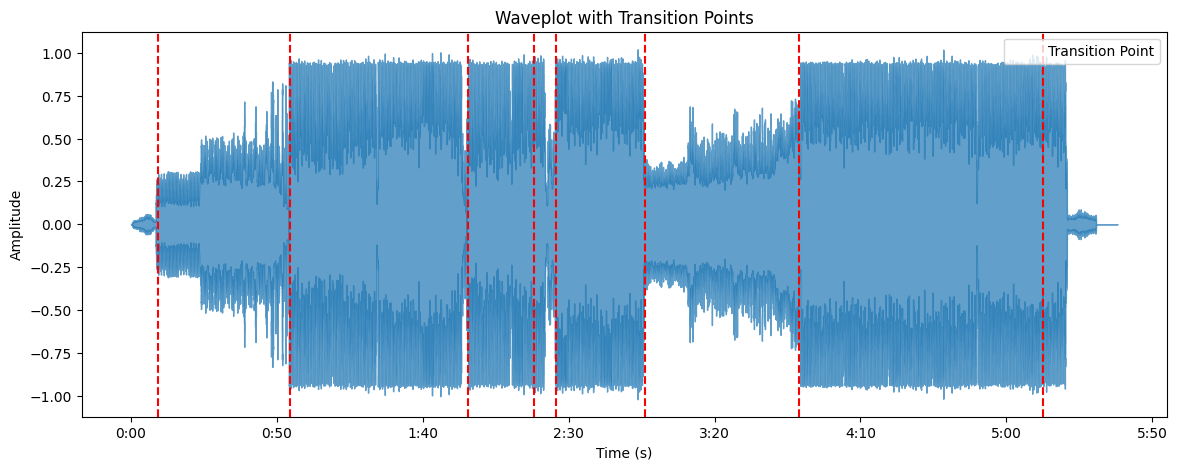

In [36]:
fx.show_transition_points()